# CE-40717: Machine Learning

## Hands-On Workshop - Third Session

### [Vectorized Operations: Optimized Computations on NumPy Arrays](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html)
Restricting the NumPy array's contents to only contain data of a single type comes at a great benefit; in `knowing` that an array's contents are homogeneous in data type, NumPy is able to delegate the task of performing mathematical operations on the array's contents to optimized, compiled C code. This is a process that is referred to as <span style="color:cyan">*Vectorization*</span>. The outcome of this can be a tremendous speedup relative to the analogous computation performed in Python, which must painstakingly check the data type of every one of the items as it iterates over the arrays, since Python typically works with lists with unrestricted contents.
<br><br/>
This part of the notebook will go through the topics in order:
>- [Universal Functions vs For Loops](#Universal-Functions-vs-For-Loops)
>    - [$L^2$ Distance](#$L^2$-Distance)
>- [Multiclass Perceptron](#Multiclass-Perceptron)
>    - [Load Data](#Load-Data)
>    - [Visualization](#Visualization)
>    - [Learning Algorithm](#Learning-Algorithm)
>    - [Training](#Training)

In [1]:
import numpy as np
import time
import os
import gzip
import struct
import matplotlib.pyplot as plt

%matplotlib inline

#### Universal Functions vs For Loops

In [2]:
n = 9999999
array = np.arange(n, dtype=np.float64)

total0 = 0
tic0 = time.time()
for i in array:
    total0 += i
toc0 = time.time()

tic1 = time.time()
total1 = array.sum()
toc1 = time.time()

print(f"Sum of the first{n:8d} natural numbers are {total0:.0f} and calculated in{toc0-tic0:7.4f} sec using for loop\
    \n\nSum of the first{n:8d} natural numbers are {total1:.0f} and calculated in{toc1-tic1:7.4f} sec using vectorization\
    \n\n{(toc0-tic0)/(toc1-tic1):.0f} times faster!")

Sum of the first 9999999 natural numbers are 49999985000001 and calculated in 3.4360 sec using for loop    

Sum of the first 9999999 natural numbers are 49999985000001 and calculated in 0.0197 sec using vectorization    

174 times faster!


Timed on my computer, the sum is over <span style="color:orange">**150**</span> times faster when performed in using NumPy's vectorized function! This should make it clear that, whenever computational efficiency is important, one should avoid performing explicit for loops over long sequences of data in Python, be them lists or NumPy arrays. NumPy provides a whole suite of vectorized functions. In fact, the name of the game when it comes to leveraging NumPy to do computations over arrays of numbers is to exclusively leverage its vectorized functions.

##### $L^2$ Distance

Suppose that we have a matrix called $X1$ which is a NumPy array with shape $(N1,D)$. This matrix has $N1$ rows and each row corresponds to a $D$-dimensional vector which we call an instance. There is also another matrix named $X2$ with the shape $(N2,D)$. Note that $N1$ is not essentially equal to $N2$.

We want to compute the $L^2$ distance between each instance in the first matrix and each instance in the second matrix. $L^2$ distance or *Euclidean distance* between two vectors $\mathbf x,\mathbf y\in\mathbb R^n$ is defined as follows:
$$d(\mathbf x,\mathbf y)=\sqrt{(x_1-y_1)^2+(x_2-y_2)^2+\dots+(x_n-y_n)^2}$$
We want to make a matrix called <span style="color:cyan">pdists</span> in which the $(i,j)_{th}$ entry is the $L^2$ distance between the $i_{th}$ instance in $X1$ and the $j_{th}$ instance in $X2$.

In [3]:
def L2_distance_1(X1, X2):
    """
    X1: NumPy 2d-array with shape (N1, D)
    X2: NumPy 2d-array with shape (N2, D)
    output: pdists which is a 2d-array with shape (N1, N2)
    """
    N1, D1 = X1.shape
    N2, D2 = X2.shape
    assert D1==D2, "Shape Mismatch!"
    pdists = -1*np.ones(shape=(N1, N2), dtype=np.float64)
    for i in range(N1):
        for j in range(N2):
            z_ij = X1[i,:]-X2[j,:]
            n_ij = (z_ij**2).sum()
            pdists[i,j] = n_ij**0.5
    return pdists

def L2_distance_2(X1, X2):
    """
    X1: NumPy 2d-array with shape (N1, D)
    X2: NumPy 2d-array with shape (N2, D)
    output: pdists which is a 2d-array with shape (N1, N2)
    """
    N1, D1 = X1.shape
    N2, D2 = X2.shape
    assert D1==D2, "Shape Mismatch!"
    pdists = -1*np.ones(shape=(N1, N2), dtype=np.float64)
    X1_square = np.sum(a=X1**2, axis=1, keepdims=True)
    X2_square = np.sum(a=X2**2, axis=1).reshape(1, N2)
    X1X2 = np.matmul(X1, X2.T)
    pdists = (X1_square - 2*X1X2 + X2_square)**0.5
    return pdists

In [4]:
X1 = np.random.randn(2017, 97)
X2 = np.random.randn(1361, 97)

tic0 = time.time()
pdists1 = L2_distance_1(X1=X1, X2=X2)
toc0 = time.time()

tic1 = time.time()
pdists2 = L2_distance_2(X1=X1, X2=X2)
toc1 = time.time()

print(f"Running time of L2_distance_1 is{toc0-tic0:8.4f} sec\
    \n\nRunning time of L2_distance_2 is{toc1-tic1:8.4f} sec\
    \n\n{(toc0-tic0)/(toc1-tic1):.0f} times faster!")

Running time of L2_distance_1 is 19.0281 sec    

Running time of L2_distance_2 is  0.5321 sec    

36 times faster!


You see a huge improvement in running time of *L2_distance_2* comparing to *L2_distance_1*. This experiment shows that how vectorized and matrix computations in NumPy could be more effiecient than just naively using for loops in Python. NumPy is a powerful module with a beautiful functional API and many of its functions are implemented in C which results in a great efficiency. Nevertheless, one of the biggest disadvantages of NumPy is that it cannot run on GPU. By using machine learning frameworks such as <span style="color:cyan">**PyTorch**</span> we will sidestep this problem.

#### Multiclass Perceptron

In machine learning, the perceptron is an algorithm for supervised learning of binary classifiers. A binary classifier is a function which can decide whether or not an input, represented by a vector of numbers, belongs to some specific class. It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. Like most other techniques for training linear classifiers, the perceptron generalizes naturally to multiclass classification. Each training instance is a feature vector <span style="color:cyan">**x**</span> and a class label <span style="color:cyan">y</span> [[1]](https://en.wikipedia.org/wiki/Perceptron#:~:text=In%20machine%20learning%2C%20the%20perceptron,supervised%20learning%20of%20binary%20classifiers.&text=It%20is%20a%20type%20of,weights%20with%20the%20feature%20vector.).

##### [Load Data](http://yann.lecun.com/exdb/mnist/)

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [5]:
def read_image(buffer):
    magic, n_img, rows, columns = struct.unpack(">IIII", buffer.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = buffer.read()
    assert len(rawbuffer) == n_img * rows * columns
    return np.frombuffer(buffer=rawbuffer, dtype="u1").reshape(n_img, rows, columns).astype(dtype=np.float16)

def read_label(buffer):
    magic, n_lab = struct.unpack(">II", buffer.read(8))
    assert magic == 0x00000801
    rawbuffer = buffer.read()
    assert len(rawbuffer) == n_lab
    return np.frombuffer(buffer=rawbuffer, dtype="u1").reshape(n_lab, 1)

In [6]:
train_data = read_image(buffer=gzip.open(filename=os.path.join(os.getcwd(), "data", "MNIST", "train-images-idx3-ubyte.gz"), mode='r'))
train_labels = read_label(buffer=gzip.open(filename=os.path.join(os.getcwd(), "data", "MNIST", "train-labels-idx1-ubyte.gz"), mode='r'))
test_data = read_image(buffer=gzip.open(filename=os.path.join(os.getcwd(), "data", "MNIST", "t10k-images-idx3-ubyte.gz"), mode='r'))
test_labels = read_label(buffer=gzip.open(filename=os.path.join(os.getcwd(), "data", "MNIST", "t10k-labels-idx1-ubyte.gz"), mode='r'))

Each one of the samples of <span style="color:cyan">MNIST</span> dataset is a $28\times28$ grayscale image. Pixel values are between 0 and 255.

##### Visualization

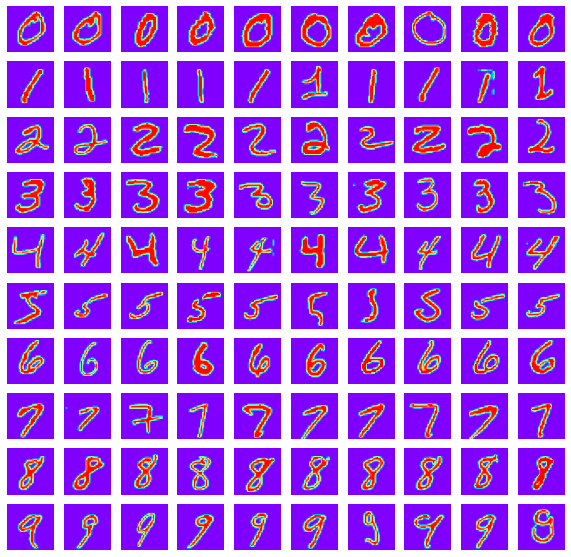

In [7]:
n, m = 10, 10
fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(n,m))

for i in range(n):
    Idx = np.where(train_labels==i)[0][:m]
    sample_imgs = train_data[Idx,:,:]/256
    for j in range(m):
        axes[i,j].imshow(X=sample_imgs[j,:,:], cmap="rainbow")
        axes[i,j].axis("off")

##### [Learning Algorithm](https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975)

[<img src="./images/Perceptron.png" width=737>](https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975)

Each class has a weight vector $\mathbf w_{y}$. The feature vector is multiplied by the weight vectors and score of class y will be $\langle\mathbf x\,,\mathbf w_{y}\rangle$. The resulting scores is used to choose the predicted class:
$$\widehat y=\underset{y}{\textbf{argmin}}\,\langle\mathbf x\,,\mathbf w_{y}\rangle$$
For learning, perceptron starts with all weights equal to zero and iterates over the examples one by one, predicting an output for each. It leaves the weights unchanged when the predicted output matches the target. If the prediction is wrong, it lowers the score of wrong answer and raise the score of right answer. Therefore, the updates become:
$$\mathbf w_{\widehat y}=\mathbf w_{\widehat y}-\mathbf x$$
$$\mathbf w_{y^*}=\mathbf w_{y^*}+\mathbf x$$
where $\widehat y$ is the predicted wrong class and $y^*$ is the right class.

<img src="./images/OMP.png" width=444>

In [8]:
class Perceptron:
    def __init__(self, feature_dim, num_classes):
        """
        This constructor initialize the weights of the model with zeros.
        """
        self.W = np.zeros((num_classes, 1+feature_dim))

    def predict(self, feature_vector):
        """
        This function returns the predicted class (y_hat) for a single instance (feature_vector).
        """
        scores = np.matmul(self.W, feature_vector.reshape(-1,1))
        y_hat = np.argmax(a=scores, axis=0)
        return y_hat

    def adjust(self, feature_vector, y):
        """
        This function gets a single training feature vector (feature_vector) with its label (y) and
        adjusts the weights of the model with perceptron algorithm.
        """
        y_hat = self.predict(feature_vector=feature_vector)
        if y_hat != y:
            self.W[y_hat,:] -= feature_vector
            self.W[y,:] += feature_vector

##### Training

In [9]:
train_ratio = 0.9
M = train_data.shape[0]
n_train_ins = int(M*train_ratio)
n = 28*28
num_classes = np.unique(train_labels).shape[0]

perm = np.random.permutation(M)
train_data_shuffled = train_data[perm].reshape(M, n)
train_labels_shuffled = train_labels[perm]

X_train, X_val = train_data_shuffled[:n_train_ins,:], train_data_shuffled[n_train_ins:,:]
y_train, y_val = train_labels_shuffled[:n_train_ins,:], train_labels_shuffled[n_train_ins:,:]
X_test, y_test = test_data.reshape(10000, n), test_labels

Let's preprocess the data by subtracting the mean of training images from all images. Preprocessing can have a huge effect on the accuracy of the model in some cases.

In [10]:
# Preprocessing
mean_img = np.mean(a=train_data.reshape(M,n), axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

# Later you see that we pass the data as a dictionary to the trainer.
data = dict(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

# Adding 1's at the begging of the feature vectors to be multiplied by bias term of weights
X_train_b = np.insert(arr=X_train, obj=0, values=1, axis=1)
X_val_b = np.insert(arr=X_val, obj=0, values=1, axis=1)
X_test_b = np.insert(arr=X_test, obj=0, values=1, axis=1)

Now let's train the model on the training set. Meanwhile, the accuracy on the validation set is printed out to make sure that the model is training well.

In [11]:
model = Perceptron(feature_dim=n, num_classes=num_classes)
val_accs = [10]

for i, (x, y) in enumerate(zip(X_train_b, y_train)):
    model.adjust(feature_vector=x, y=y)
    if i%1000 == 999:        
        pred_on_val = [model.predict(feature_vector=x) for x in X_val_b]
        val_acc = 100*np.sum(pred_on_val==y_val)/X_val_b.shape[0]
        val_accs.append(val_acc)
        print(f"At iteration {i+1:5d} accuracy on validation set is:{val_acc:6.2f}%")

At iteration  1000 accuracy on validation set is: 79.07%
At iteration  2000 accuracy on validation set is: 79.00%
At iteration  3000 accuracy on validation set is: 80.87%
At iteration  4000 accuracy on validation set is: 81.27%
At iteration  5000 accuracy on validation set is: 83.03%
At iteration  6000 accuracy on validation set is: 82.43%
At iteration  7000 accuracy on validation set is: 84.82%
At iteration  8000 accuracy on validation set is: 83.63%
At iteration  9000 accuracy on validation set is: 84.47%
At iteration 10000 accuracy on validation set is: 85.80%
At iteration 11000 accuracy on validation set is: 85.57%
At iteration 12000 accuracy on validation set is: 83.82%
At iteration 13000 accuracy on validation set is: 83.65%
At iteration 14000 accuracy on validation set is: 84.35%
At iteration 15000 accuracy on validation set is: 86.10%
At iteration 16000 accuracy on validation set is: 84.58%
At iteration 17000 accuracy on validation set is: 84.58%
At iteration 18000 accuracy on 

Let's plot the accuracy on validation set:

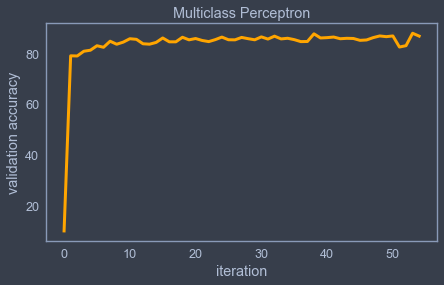

In [12]:
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", grid=False)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
axes.plot(val_accs, c="orange", lw=3)
axes.set_xlabel(xlabel="iteration")
axes.set_ylabel(ylabel="validation accuracy")
axes.set_title(label="Multiclass Perceptron");

Finally let's test the model on the test set:

In [13]:
pred_on_test = [model.predict(feature_vector=x) for x in X_test_b]
test_acc = 100*np.sum(pred_on_test==y_test)/X_test_b.shape[0]
print(f"Accuracy on test set is:{test_acc:6.2f}%")

Accuracy on test set is: 86.90%
